<a href="https://colab.research.google.com/github/Euan-J-Austin/Analytics_and_Intelligence/blob/main/RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value-based segmentation

Pareto rule ... 20% causes result in 80% of the consequences e.g. 20% customers result in 80% profit, 80% customers result in 20% profit

# What is RFM?



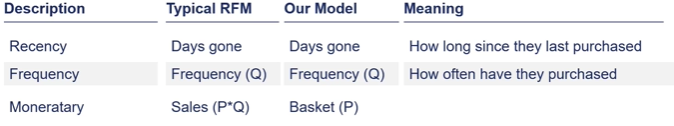

Basket is average purchase value, P*Q not used because overlap with frequency

What else could be added?

.Churn

.Time

.Average profit per order for Monetary

## How does it work?

Divided into quartiles

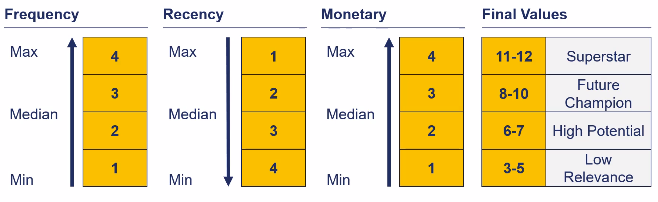

# Building RFM model

In [32]:
#Directories and libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt


In [33]:
data = pd.read_csv('/content/online_shoppers.csv', encoding = "ISO-8859-1").dropna()

In [34]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom


In [60]:
data.describe()

,Quantity,UnitPrice,CustomerID,sales
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854
std,248.693370,69.315162,1713.600303,427.591718
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [61]:
data['CustomerID'].nunique()

4372

## Data preparation

In [35]:
#Creating sales column
data['sales'] = data['Quantity'] * data['UnitPrice']

In [36]:
data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom,15.3


In [37]:
#Dates - Transform date variable
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 406829, dtype: datetime64[ns]

In [38]:
#get last date available
snapshot_date = data['InvoiceDate'].max() + timedelta(days = 1)
#added one day so purchases will have a recency of 1
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [39]:
#aggregate on a customer level

df = data.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    #last date less customers last purchase date, represent by x
    #specifying days means time is ignored
    'InvoiceNo': 'count',
    'sales': 'sum'
})
df.head()

,InvoiceDate,InvoiceNo,sales
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [40]:
no_customers = len(df)

In [41]:
#Create basket / monetary variable

df['Monetary'] = df.sales / df.InvoiceNo
df.head(3)

,InvoiceDate,InvoiceNo,sales,Monetary
CustomerID,,,,
12346.0,326,2,0.00,0.000000
12347.0,2,182,4310.00,23.681319
12348.0,75,31,1797.24,57.975484


In [42]:
# what about avergae date between each invoice? fixed schedule

In [43]:
df = df.drop(columns = 'sales')
df.head(0)

,InvoiceDate,InvoiceNo,Monetary
CustomerID,,,


In [44]:
df = df.rename(columns = {'InvoiceDate': 'Recency',
                     'InvoiceNo': 'Frequency',})

df.head(0)

,Recency,Frequency,Monetary
CustomerID,,,


## Quartiles

In [45]:
df['F'] = pd.qcut(x = df['Frequency'], q = 4, labels = range(1, 5, 1))
df['M'] = pd.qcut(x = df['Monetary'], q = 4, labels = range(1, 5, 1))
df['R'] = pd.qcut(x = df['Recency'], q = 4, labels = range(4, 0, -1))
df.head()

,Recency,Frequency,Monetary,F,M,R
CustomerID,,,,,,
12346.0,326,2,0.000000,1,1,1
12347.0,2,182,23.681319,4,4,4
12348.0,75,31,57.975484,2,4,2
12349.0,19,73,24.076027,3,4,3
12350.0,310,17,19.670588,1,3,1


## RFM Score

In [46]:
df['RFM'] = df[['R', 'F', 'M']].sum(axis = 1)
df.head()

,Recency,Frequency,Monetary,F,M,R,RFM
CustomerID,,,,,,,
12346.0,326,2,0.000000,1,1,1,3
12347.0,2,182,23.681319,4,4,4,12
12348.0,75,31,57.975484,2,4,2,8
12349.0,19,73,24.076027,3,4,3,10
12350.0,310,17,19.670588,1,3,1,5


## RFM Function

In [47]:
def rfm_segment(df):
  if df['RFM'] >= 11:
    return 'Superstar'
  elif ((df['RFM'] >= 8) and ((df['RFM'] < 11))):
    return 'Future Champion'
  elif ((df['RFM'] >= 6) and ((df['RFM'] < 8))):
    return 'High Potential'
  else:
    return 'Low Relevance'

## RFM

In [48]:
df['RFM_level'] = df.apply(rfm_segment, axis = 1)
df.head()

,Recency,Frequency,Monetary,F,M,R,RFM,RFM_level
CustomerID,,,,,,,,
12346.0,326,2,0.000000,1,1,1,3,Low Relevance
12347.0,2,182,23.681319,4,4,4,12,Superstar
12348.0,75,31,57.975484,2,4,2,8,Future Champion
12349.0,19,73,24.076027,3,4,3,10,Future Champion
12350.0,310,17,19.670588,1,3,1,5,Low Relevance


In [49]:
df.tail()

,Recency,Frequency,Monetary,F,M,R,RFM,RFM_level
CustomerID,,,,,,,,
18280.0,278,10,18.060000,1,3,1,5,Low Relevance
18281.0,181,7,11.545714,1,2,1,4,Low Relevance
18282.0,8,13,13.584615,1,2,4,7,High Potential
18283.0,4,756,2.771005,4,1,4,9,Future Champion
18287.0,43,70,26.246857,3,4,3,10,Future Champion


In [50]:
import numpy as np

In [51]:
pareto_test = no_customers = len(df) / df['RFM_level'].value_counts()['Superstar']
print(pareto_test)

#check variable use here?, denominator and numerator should be switched

11.689839572192513


In [52]:
RFM_level_tbl = df.groupby("RFM_level").agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
})

RFM_level_tbl

Recency   Frequency   Monetary      
                       mean        mean       mean count
RFM_level                                               
Future Champion   32.007919  135.835973  30.169670  1768
High Potential   118.708869   39.213947  38.033024  1477
Low Relevance    221.483400   22.811421  -0.586430   753
Superstar          9.973262  244.852941  45.483949   374

In [53]:
total_customers = RFM_level_tbl['Monetary']['count'].sum() # can use this to add proportion column

In [54]:
RFM_level_tbl['Proportion'] = round((RFM_level_tbl['Monetary']['count']/total_customers)*100, 2)

In [55]:
print(RFM_level_tbl)

                    Recency   Frequency   Monetary       Proportion
                       mean        mean       mean count           
RFM_level                                                          
Future Champion   32.007919  135.835973  30.169670  1768      40.44
High Potential   118.708869   39.213947  38.033024  1477      33.78
Low Relevance    221.483400   22.811421  -0.586430   753      17.22
Superstar          9.973262  244.852941  45.483949   374       8.55


In [56]:
#how to account for negative monetary mean? refund/credit? or bad data
#nb the mean for high potential is greater than the mean for future champion

In [59]:
negative_monetary_df = df.loc[df['Monetary'] < 0]
negative_monetary_df.head()

,Recency,Frequency,Monetary,F,M,R,RFM,RFM_level
CustomerID,,,,,,,,
12503.0,338,1,-1126.00,1,1,1,3,Low Relevance
12505.0,301,1,-4.50,1,1,1,3,Low Relevance
12605.0,365,3,-2.50,1,1,1,3,Low Relevance
12666.0,359,2,-113.72,1,1,1,3,Low Relevance
12870.0,366,2,-7.45,1,1,1,3,Low Relevance
